### Thanksgiving 2018

- started fire at 11 am using Minion method
- Placed turkey at 11:40 am
- vents fully open


In [234]:
import numpy,pandas
from collections import OrderedDict
import seaborn
import matplotlib.pyplot as plt
import sklearn.linear_model
from datetime import datetime




In [269]:
day='11-22-2018'
temptimes = OrderedDict({'11:42':[90,46],
            '11:43':[183,46],
            '11:46':[250,48],
            '11:52':[261,50],
            '12:03':[280,59],
            '12:11':[268,68],
            '12:18':[264,75],
            '12:26':[266,84],
            '12:34':[291,91],
            '12:37':[297,93],
            '12:41':[306,97],
            '12:49':[313,102],
            '12:53':[313,104],
            '12:58':[307,108],
            '13:10':[307,117],
            '13:16':[313,120],
            '13:22':[316,124],
            '13:31':[295,129],
            '13:38':[291,133],
            '13:44':[298,135],
            '13:52':[304,138],
            '13:59':[315,142],
            '14:08':[313,145],
            '14:16':[313,149],
            '14:30':[309,154],
            '14:39':[298,158]})

pdtimes = [pandas.to_datetime('%s %s'%(day,i), dayfirst=True) for i in temptimes]
internal = [temptimes[i][1] for i in temptimes]
air = [temptimes[i][0] for i in temptimes]

bbqdata = pandas.DataFrame({'air':air,'internal':internal},index=pdtimes)
bbqdata['time']=bbqdata.index
bbqdata_tidy = bbqdata.melt(value_vars=['air','internal'],
                            value_name='temperature',var_name='probe',
                           id_vars='time')


### Plot the data

- vertical green lines show times when I opened the large door to let in more air in order to stoke the fire

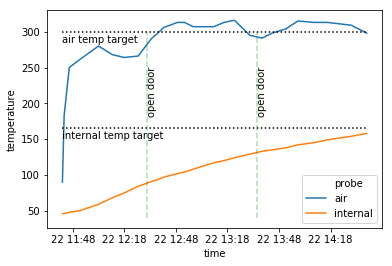

In [270]:
seaborn.lineplot(data=bbqdata_tidy,x='time',
               y='temperature',hue='probe')
plt.plot([bbqdata.time.min(),bbqdata.time.max()],[300,300],'k:')
plt.text(bbqdata.time.min(),285,'air temp target')
plt.text(bbqdata.time.min(),150,'internal temp target')
plt.plot([bbqdata.time.min(),bbqdata.time.max()],[165,165],'k:')
ax=plt.gca()

# add custom stuff
# opened door at 12:31
opentime=[pandas.to_datetime('%s 12:31'%day),
         pandas.to_datetime('%s 13:35'%day)]
for o in opentime:
    plt.plot([o,o],[40,300],'g--',alpha=0.3)
    plt.text(o,240,'open door',rotation=90)
    
ventclose = []
ventopen = []



### plot predicted completion time

last time around the temperature increase slowed down over time, so we use a quadratic model

In [271]:
lr=sklearn.linear_model.LinearRegression()
bbqdata['timenum']=pandas.to_numeric(bbqdata.time)
lr.fit(bbqdata.timenum[:,numpy.newaxis],bbqdata.internal)

# fit polynomial
poly = PolynomialFeatures(degree=2)
X = bbqdata.timenum[:,numpy.newaxis] - numpy.min(bbqdata.timenum[:,numpy.newaxis])
X=X/10000000000
X_ = poly.fit_transform(X)
pr=sklearn.linear_model.LinearRegression()
pr.fit(X_,bbqdata.internal)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [272]:
start = datetime(2018, 11, 22,11,42,00)
end = datetime(2018, 11, 22,17,00,00)

time_index = pandas.date_range(start, end,periods=100)
time_index_num = pandas.to_numeric(time_index)


predicted=lr.predict(time_index_num[:,numpy.newaxis])
target=165
completion_time=time_index[numpy.where(predicted>target)[0][0]]
print('predicted completion time (linear regression):',completion_time)

# quadratic
newX = (time_index_num[:,numpy.newaxis]-numpy.min(bbqdata.timenum[:,numpy.newaxis]))/10000000000
predicted_poly=pr.predict(poly.fit_transform(newX))

completion_time=time_index[numpy.where(predicted_poly>=max(predicted_poly))[0][0]]
print('predicted completion time (linear regression):',completion_time)





predicted completion time (linear regression): 2018-11-22 14:35:27.272727296
predicted completion time (linear regression): 2018-11-22 15:46:07.272727296


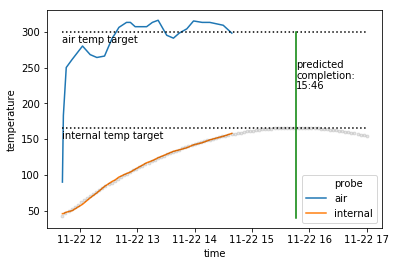

In [273]:

seaborn.lineplot(data=bbqdata_tidy,x='time',
               y='temperature',hue='probe')
plt.plot(time_index,predicted_poly,'k.',alpha=0.1)
plt.text(completion_time,250,'predicted')
plt.text(completion_time,235,'completion:')
plt.text(completion_time,220,'%d:%d'%(completion_time.hour,
                                     completion_time.minute))


plt.plot([bbqdata.time.min(),time_index.max()],[300,300],'k:')
plt.text(bbqdata.time.min(),285,'air temp target')
plt.text(bbqdata.time.min(),150,'internal temp target')
plt.plot([bbqdata.time.min(),time_index.max()],[165,165],'k:')
plt.plot([completion_time,completion_time],[40,300],'g-')
